<a href="https://colab.research.google.com/github/bhav380-2/Deep-Learning/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
from torch.nn import init
import torchvision
import torchvision.transforms as T
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import torchvision.datasets as dset

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

%matplotlib inline

In [ ]:
plt.rcParams['figure.figsize'] = (10.0,8.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def show_images(images):
  # print("********* image dimension before reshape", images.shape)
  images = np.reshape(images,[images.shape[0],-1])
  # print("********* image dimension after reshape", images.shape)
  sqrtn = int(np.ceil(np.sqrt(images.shape[0])))
  sqrtimg = int(np.ceil(np.sqrt(images.shape[1])))
  fig = plt.figure(figsize=(sqrtn,sqrtn))
  gs = gridspec.GridSpec(sqrtn,sqrtn)
  gs.update(wspace=0.05,hspace=0.05)

  for i,img in enumerate(images):
    ax = plt.subplot(gs[i])
    plt.axis('off')
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.set_aspect('equal')
    plt.imshow(img.reshape([sqrtimg,sqrtimg]))

def plot_gan_losses(history):
    plt.figure(figsize=(10, 5))
    plt.title("Generator and Discriminator Loss During Training")
    plt.plot(history['epochs'], history['g_loss'], label="G Loss")
    plt.plot(history['epochs'], history['d_loss'], label="D Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    plt.show()


def create_checkpoint(G,D,G_SOLVER,D_SOLVER,history,file_name):
  checkpoint = {
    'epoch': 10,
    'generator_state_dict': G.state_dict(),
    'discriminator_state_dict': D.state_dict(),
    'G_optimizer_state_dict': G_SOLVER.state_dict(),
    'D_optimizer_state_dict': D_SOLVER.state_dict(),
    'loss_history': history
  }
  torch.save(checkpoint,file_name)

def preprocess_img(x):
  return 2*x-1.0

def deprocess_img(x):
  return (x+1.0)/2.0

def rel_error(x,y):
  return np.max(np.abs(x-y) / (np.maximum(1e-8, np.abs(x)+np.abs(y))))

def count_params(model):
  param_count = np.sum([np.prod(p.size()) for p in model.parameters()])
  return param_count

answers = dict(np.load('gan-checks-tf.npz'))


# Dataset

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.48MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 129kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.24MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 11.8MB/s]


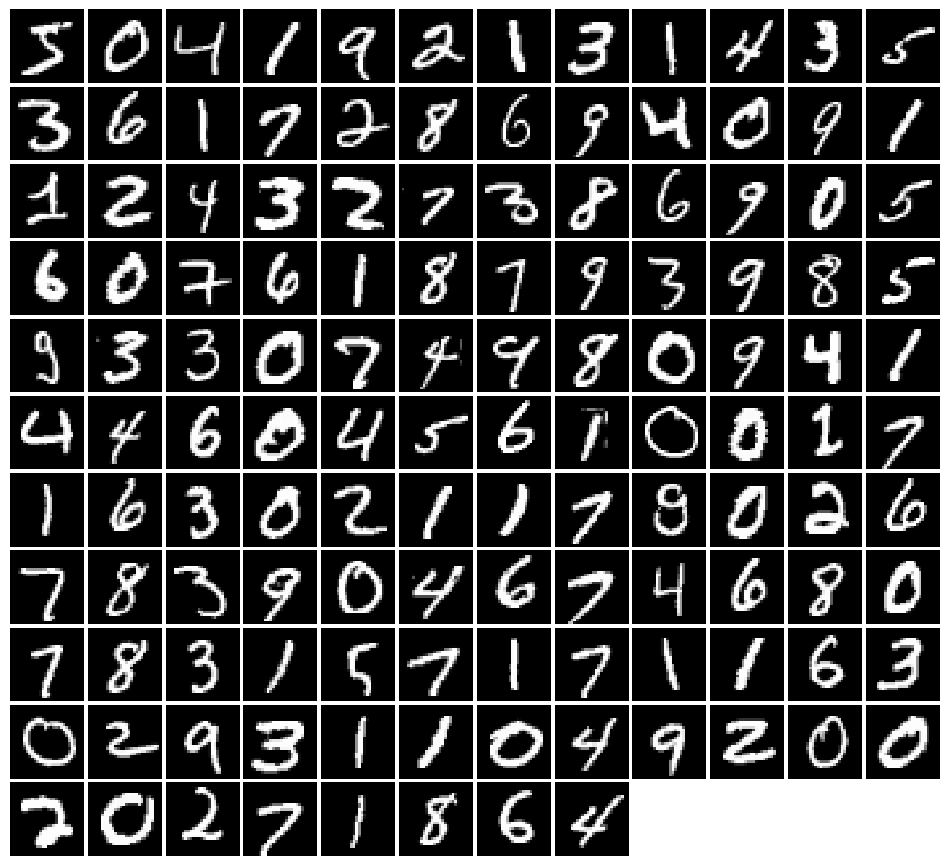

In [ ]:
class ChunkSampler(sampler.Sampler):
  def __init__(self,num_samples,start=0):
    self.num_samples = num_samples
    self.start = start

  def __iter__(self):
    return iter(range(self.start,self.start+self.num_samples))

  def __len__(self):
    return self.num_samples

NUM_TRAIN = 50000
NUM_VAL = 5000

NOISE_DIM = 96
batch_size = 128

mnist_train = dset.MNIST('./datasets/MNIST_data',train=True,download=True, transform=T.ToTensor())
loader_train = DataLoader(mnist_train, batch_size = batch_size, sampler = ChunkSampler(NUM_TRAIN,0))

mnist_val = dset.MNIST('./datasets/MNIST_data',train=True,download=True, transform=T.ToTensor())
loader_val = DataLoader(mnist_val,batch_size = batch_size , sampler = ChunkSampler(NUM_VAL,NUM_TRAIN))

data_iter = iter(loader_train)
images, _ = next(data_iter)
show_images(images)

# Create Random Noise
## for GAN

In [ ]:
def sample_noise(batch_size,dim):
  return torch.FloatTensor(batch_size,dim).uniform_(-1,1)

sample_noise(128,28)

tensor([[ 0.3285,  0.9053, -0.7140,  ..., -0.3897,  0.6458,  0.2438],
        [-0.7303, -0.6489,  0.6323,  ...,  0.2000, -0.7363,  0.6438],
        [-0.3657,  0.9225,  0.1036,  ..., -0.4346, -0.6170, -0.1149],
        ...,
        [ 0.8052, -0.3353, -0.2172,  ...,  0.0470, -0.5819, -0.4799],
        [-0.3514,  0.2221,  0.4596,  ..., -0.2335, -0.5905, -0.6528],
        [ 0.6456,  0.2962, -0.8552,  ..., -0.5307, -0.9347,  0.9760]])

In [ ]:
def test_sample_noise():
  batch_size = 3
  dim = 4
  torch.manual_seed(231)
  z = sample_noise(batch_size,dim)
  np_z = z.cpu().numpy()
  assert np_z.shape == (batch_size,dim)
  assert torch.is_tensor(z)
  assert np.all(np_z >=-1.0) and np.all(np_z<=1.0)
  assert np.any(np_z <0.0) and np.any(np_z > 0.0)
  print("All tests passed!")

test_sample_noise()

All tests passed!


# GAN Architecture

## Flatten for Implementing Convulational Generator

In [ ]:
class Flatten(nn.Module):
  def forward(self,x):
    N, C, H, W = x.size()
    return x.view(N, -1)

class Unflatten(nn.Module):
  def __init__(self, N=-1, C=128, H=7, W=7):
    super(Unflatten, self).__init__()
    self.N = N
    self.C = C
    self.H = H
    self.W = W

  def forward(self,x):
    return x.view(self.N, self.C, self.H, self.W)

  def initialize_weights(m):
    if isinstance(m,nn.Linear) or isinstance(m,nn.ConvTranspose2d):
      init.xavier_uniform_(m.weight.data)




In [ ]:
dtype = torch.FloatTensor

## Discriminator

In [ ]:
def discriminator():
  model = nn.Sequential(
      Flatten(),
      # layer 1
      nn.Linear(784,600),
      nn.LeakyReLU(0.2,inplace=True),
      #layer 2
      nn.Linear(600,600),
      nn.LeakyReLU(0.1,inplace=True),
      nn.Linear(600,256),
      nn.LeakyReLU(0.2,inplace=True),
      #final layer
      nn.Linear(256,1),
  )
  return model




In [ ]:
# parameters -> (x+1) * y

def test_discriminator(true_count=832201):
  model = discriminator()
  cur_count = count_params(model)
  if cur_count != true_count:
    print('Incorrect number of parameters in discriminator. Check your achitecture.')
  else:
    print('Correct number of parameters in discriminator.')

test_discriminator()


Correct number of parameters in discriminator.


## Generator

In [ ]:
def generator(noise_dim=NOISE_DIM):
  model = nn.Sequential(
      #Layer 1
      nn.Linear(noise_dim,2048),
      nn.ReLU(inplace=True),
      nn.Linear(2048,1024),
      nn.ReLU(inplace=True),
      nn.Linear(1024,1024),
      nn.ReLU(inplace=True),
      nn.Linear(1024,784),
      nn.Tanh()
  )
  return model


In [ ]:
def test_generator(true_count=840100):
    model = generator(4)
    cur_count = count_params(model)
    if cur_count != true_count:
        print('Incorrect number of parameters in generator. Check your achitecture.')
    else:
        print('Correct number of parameters in generator.')

test_generator()



# GAN Loss

In [ ]:
def bce_loss(input,target):
  # bce = max(x,0) - xy + log(1+ e^-|x|) -->>
  neg_abs = -input.abs()
  loss = input.clamp(min=0) - input * target + (1+neg_abs.exp()).log()
  return loss.mean()



In [ ]:
def discriminator_loss(logits_real,logits_fake):
  N,_ = logits_real.size()
  loss = (bce_loss(logits_real,torch.ones(N).type(dtype))) + (bce_loss(logits_fake,torch.zeros(N).type(dtype)))
  return loss

def generator_loss(logits_fake):
  N,_ = logits_fake.size()
  loss = (bce_loss(logits_fake, torch.ones(N).type(dtype)))
  return loss

In [1]:
def test_discriminator_loss(logits_real, logits_fake, d_loss_true):
    d_loss = discriminator_loss(torch.Tensor(logits_real).type(dtype),
                                torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in d_loss: %g"%rel_error(d_loss_true, d_loss))

test_discriminator_loss(answers['logits_real'], answers['logits_fake'],
                        answers['d_loss_true'])

In [ ]:
def test_generator_loss(logits_fake, g_loss_true):
    g_loss = generator_loss(torch.Tensor(logits_fake).type(dtype)).cpu().numpy()
    print("Maximum error in g_loss: %g"%rel_error(g_loss_true, g_loss))

test_generator_loss(answers['logits_fake'], answers['g_loss_true'])



## Optimizing loss

In [2]:
def get_optimizer(model):
  optimizer = optim.Adam(model.parameters(),lr = 1e-3 , betas=(0.5,0.999))
  return optimizer


# Train GAN

In [ ]:
def run_a_gan(D,G,D_solver,G_solver,discriminator_loss,generator_loss,show_every=250, batch_size=128,noise_size=96,num_epochs=10):
  # Train GAN
  history = {
        'd_loss': [],
        'g_loss': [],
        'epochs': []
    }

  iter_count = 0
  for epoch in range(num_epochs):
    print("***************** running Epoch********************* ",epoch)
    epoch_d_loss = 0
    epoch_g_loss = 0
    batch_count = 0
    for x,_ in loader_train:
      if len(x) != batch_size:
        continue
      D_solver.zero_grad()
      real_data = x.type(dtype)
      ## possible bug
      ## - check scaling of input image pixels
      ## - tanh and sigmoid activation in generator's final layer
      logits_real = D(2*(real_data-0.5)).type(dtype)

      g_fake_seed = sample_noise(batch_size,noise_size).type(dtype)
      fake_images = G(g_fake_seed).detach()
      logits_fake = D(fake_images.view(batch_size,1,28,28))

      d_total_error = discriminator_loss(logits_real,logits_fake)
      d_total_error.backward()
      D_solver.step()

      G_solver.zero_grad()
      g_fake_seed = sample_noise(batch_size,noise_size).type(dtype)
      fake_images = G(g_fake_seed)

      gen_logits_fake = D(fake_images.view(batch_size,1,28,28))
      g_error = generator_loss(gen_logits_fake)
      g_error.backward()
      G_solver.step()
      epoch_d_loss += d_total_error.item()
      epoch_g_loss += g_error.item()
      batch_count += 1

      if(iter_count%show_every==0):
        print('Iter: {}, D: {:.4}, G:{:.4}'.format(iter_count,d_total_error.item(),g_error.item()))
        imgs_numpy = fake_images.data.cpu().numpy()
        show_images(imgs_numpy[0:16])
        plt.show()
        print()
      iter_count+=1

    avg_d = epoch_d_loss / batch_count
    avg_g = epoch_g_loss / batch_count
    history['d_loss'].append(avg_d)
    history['g_loss'].append(avg_g)
    history['epochs'].append(epoch)

  return history

In [ ]:
# Make the discriminator
D = discriminator().type(dtype)

# create generator
G = generator().type(dtype)

D_solver = get_optimizer(D)
G_solver = get_optimizer(G)
# Run it
# history = run_a_gan(D,G,D_solver,G_solver,discriminator_loss,generator_loss)

In [ ]:
# checkpoint = {
#     'epoch': 10,
#     'generator_state_dict': G.state_dict(),
#     'discriminator_state_dict': D.state_dict(),
#     'G_optimizer_state_dict': G_solver.state_dict(),
#     'D_optimizer_state_dict': D_solver.state_dict(),
#     'loss_history': history
# }
# torch.save(checkpoint, 'gan_my_checkpoint.pth')

In [ ]:
checkpoint = torch.load("./gan_my_checkpoint.pth")

In [ ]:
history = checkpoint.get("loss_history")

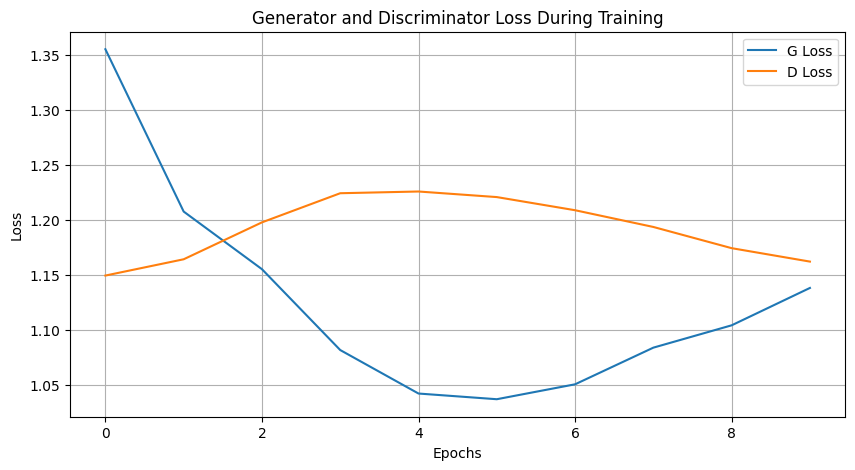

In [ ]:
plot_gan_losses(history)

# Least Squares GAN

##### Source :- Research Paper Generative Adversarial Nets 2014

### Formula 1
a=1, b=-1 , c=0

min
D V LSGAN (D) = 1/
2 E x∼p data (x)
[(D(x) − 1)^2 ] + 1
/2 E z∼p z (z)
[(D(G(z)) + 1) ^2 ]

min
G V LSGAN (G) = 1
/2 E z∼p z (z)
[(D(G(z)))^2]



### Formula 2
c=b

min
D V LSGAN (D) = 1
/2 E x∼p data (x)
[(D(x) − 1)^2 ] + 1
/2 E z∼p z (z)
[(D(G(z)))^2 ]

min
G V LSGAN (G) = 1
/2 E z∼p z (z)
[(D(G(z)) − 1)^2]

## LestSquares GAN Loss function using Formula 1

In [ ]:
def ls_discriminator_loss(scores_real,scores_fake):
  N,_ = scores_real.size()
  loss = (0.5*torch.mean((scores_real-torch.ones(N).type(dtype))**2)) + (0.5* torch.mean((scores_fake + torch.ones(N).type(dtype))**2))
  return loss

def ls_generator_loss(scores_fake):
  N,_ = scores_fake.size()
  loss = 0.5*torch.mean((scores_fake)**2)
  return loss

In [ ]:
def test_lsgan_loss(score_real,score_fake,d_loss_true,g_loss_true):
  scores_real = torch.Tensor(score_real).type(dtype)
  scores_fake = torch.Tensor(score_fake).type(dtype)
  d_loss = ls_discriminator_loss(scores_real,scores_fake).cpu().numpy()
  g_loss = ls_generator_loss(scores_fake).cpu().numpy()
  print("Maximum error in d_loss: %g"%rel_error(d_loss_true,d_loss))
  print("Maximum error in g_loss: %g"%rel_error(g_loss_true,g_loss))

test_lsgan_loss(answers['logits_real'], answers['logits_fake'],answers['d_loss_lsgan_true'], answers['g_loss_lsgan_true'])

Maximum error in d_loss: 0.113753
Maximum error in g_loss: 0.464396


***************** running Epoch*********************  0
Iter: 0, D: 1.035, G:8.409e-05


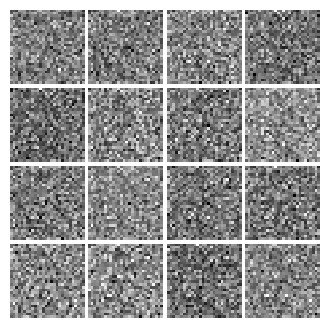


Iter: 250, D: 0.4814, G:0.1071


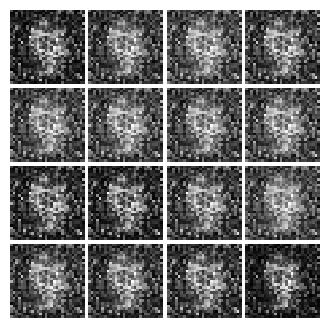


***************** running Epoch*********************  1
Iter: 500, D: 0.519, G:0.1819


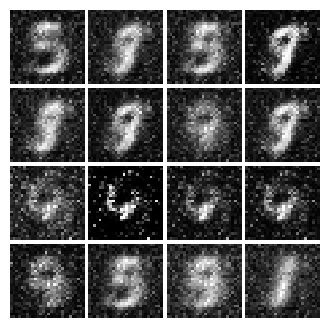


Iter: 750, D: 0.6222, G:0.1575


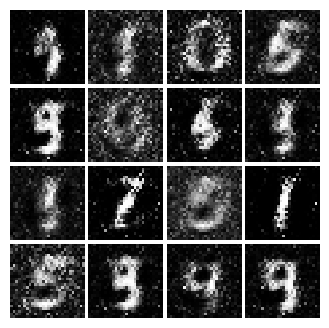


***************** running Epoch*********************  2
Iter: 1000, D: 0.6232, G:0.1687


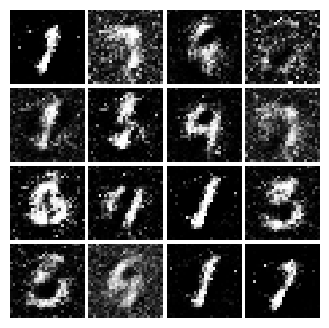


***************** running Epoch*********************  3
Iter: 1250, D: 0.7114, G:0.3683


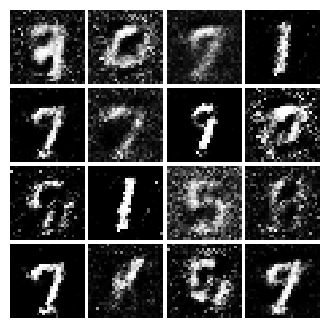


Iter: 1500, D: 0.6485, G:0.1705


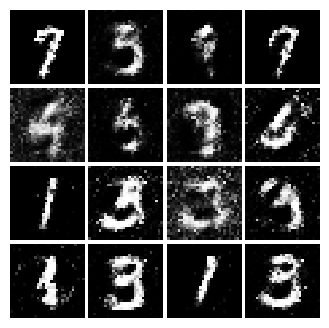


***************** running Epoch*********************  4
Iter: 1750, D: 0.6818, G:0.1578


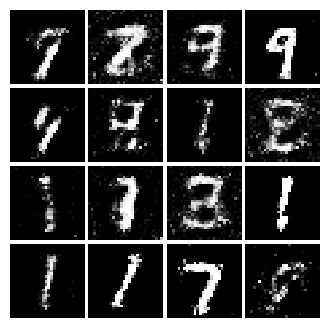


***************** running Epoch*********************  5
Iter: 2000, D: 0.6843, G:0.07973


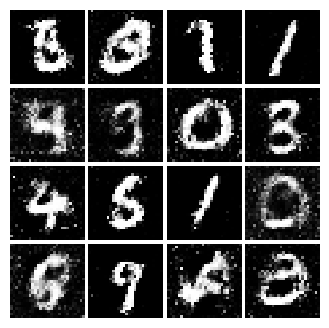


Iter: 2250, D: 0.7097, G:0.4062


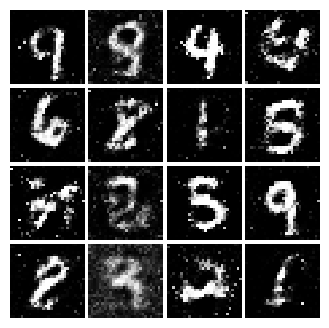


***************** running Epoch*********************  6
Iter: 2500, D: 0.5654, G:0.2016


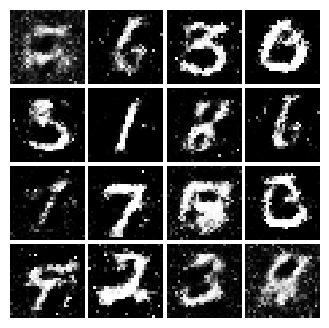


***************** running Epoch*********************  7
Iter: 2750, D: 0.7675, G:0.07161


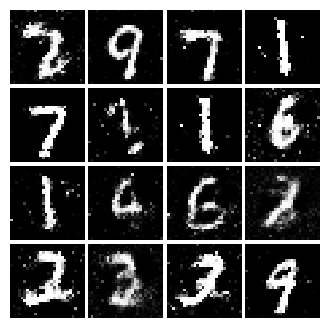


Iter: 3000, D: 0.6321, G:0.09111


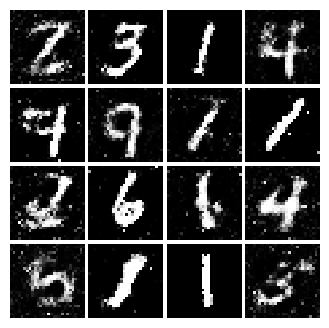


***************** running Epoch*********************  8
Iter: 3250, D: 0.6876, G:0.1184


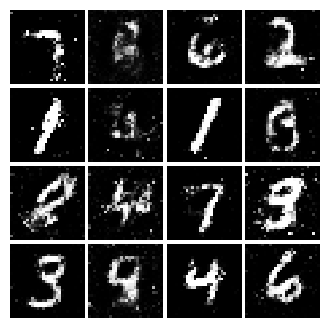


Iter: 3500, D: 0.7122, G:0.3609


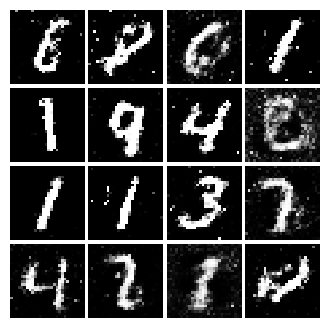


***************** running Epoch*********************  9
Iter: 3750, D: 0.6832, G:0.1439


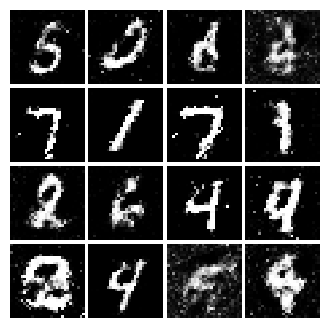

In [ ]:
LS_D = discriminator().type(dtype)
LS_G = generator().type(dtype)

LS_D_SOLVER = get_optimizer(LS_D)
LS_G_SOLVER = get_optimizer(LS_G)

ls_history = run_a_gan(LS_D,LS_G,LS_D_SOLVER,LS_G_SOLVER,ls_discriminator_loss,ls_generator_loss)
create_checkpoint(LS_G,LS_D,LS_G_SOLVER,LS_D_SOLVER,ls_history,'ls_gan_my_checkpoint.pth')


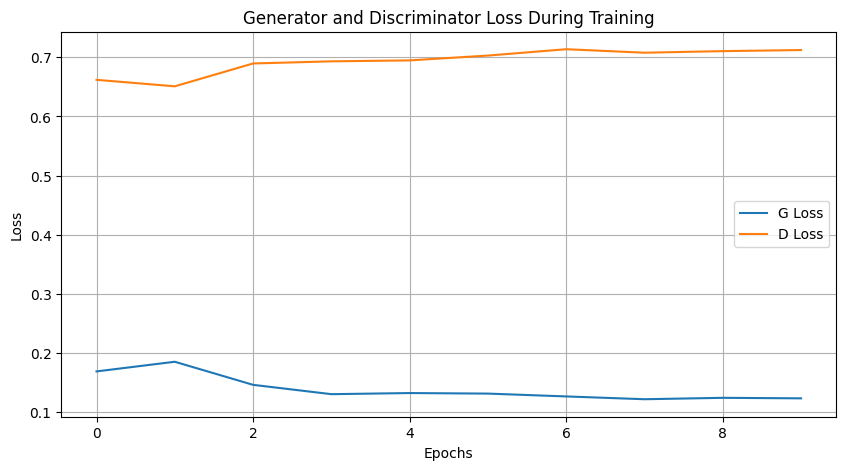

In [ ]:
plot_gan_losses(ls_history)

Forumla 1 doesn't performed well
Formula 1 pushes the generated images towards decision boundary between real and fake images

## LestSquares GAN Loss function using Formula 2


In [ ]:


def ls_discriminator_loss2(scores_real, scores_fake):
    N,_ = scores_real.size()
    loss = (0.5 * torch.mean((scores_real-torch.ones(N).type(dtype))**2)) + (0.5 * torch.mean(scores_fake**2))
    return loss

def ls_generator_loss2(scores_fake):
    N,_ = scores_fake.size()
    loss = (0.5 * torch.mean((scores_fake-torch.ones(N).type(dtype))**2))
    return loss


***************** running Epoch*********************  0
Iter: 0, D: 0.551, G:0.4459


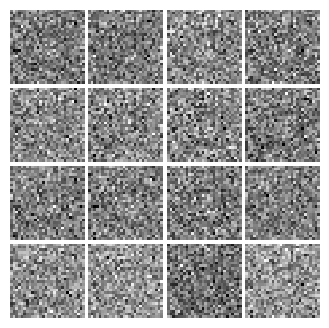


Iter: 250, D: 0.3499, G:0.5994


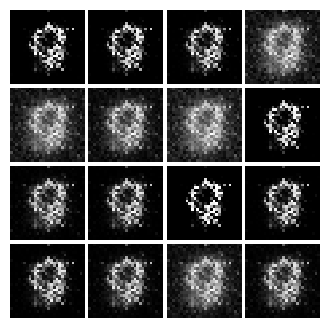


***************** running Epoch*********************  1
Iter: 500, D: 0.1813, G:0.1677


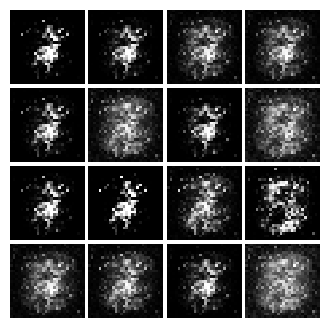


Iter: 750, D: 0.1765, G:0.1768


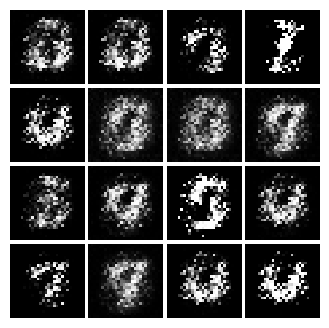


***************** running Epoch*********************  2
Iter: 1000, D: 0.1534, G:0.6098


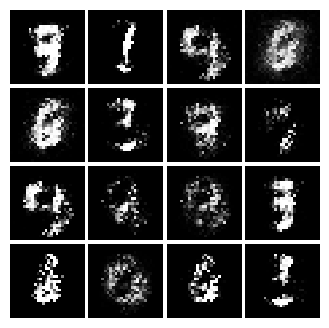


***************** running Epoch*********************  3
Iter: 1250, D: 0.1547, G:0.2645


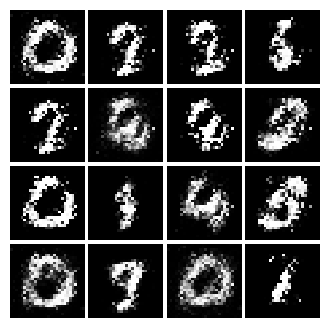


Iter: 1500, D: 0.1751, G:0.2249


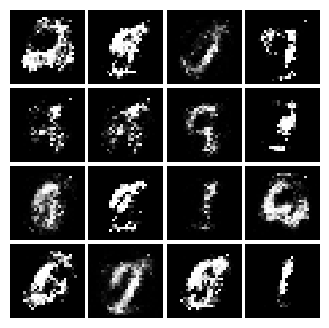


***************** running Epoch*********************  4
Iter: 1750, D: 0.248, G:0.2975


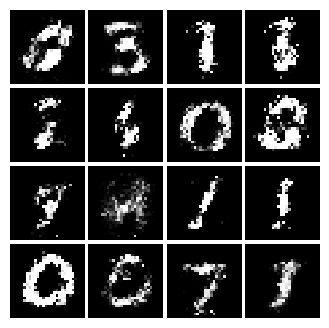


***************** running Epoch*********************  5
Iter: 2000, D: 0.2597, G:0.2258


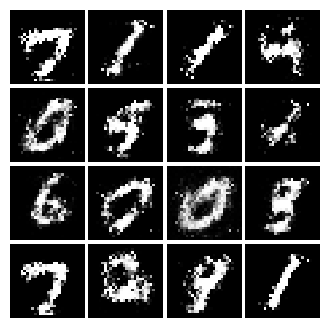


Iter: 2250, D: 0.1938, G:0.2183


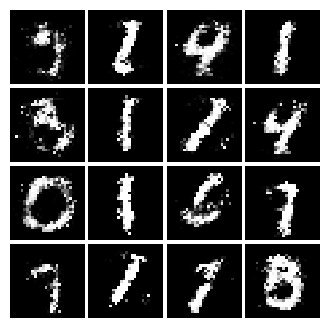


***************** running Epoch*********************  6
Iter: 2500, D: 0.1551, G:0.3154


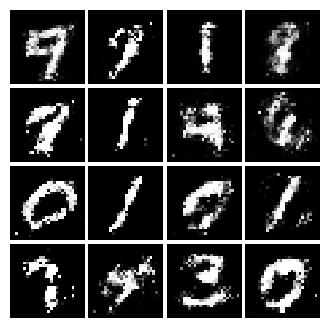


***************** running Epoch*********************  7
Iter: 2750, D: 0.3362, G:0.1961


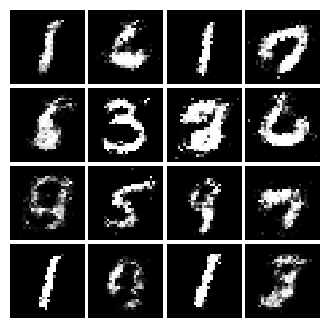


Iter: 3000, D: 0.2615, G:0.1277


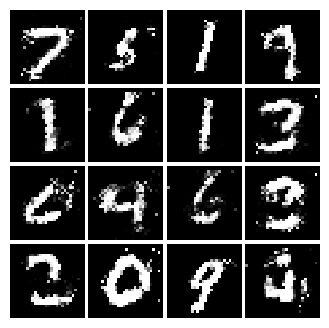


***************** running Epoch*********************  8
Iter: 3250, D: 0.2289, G:0.2192


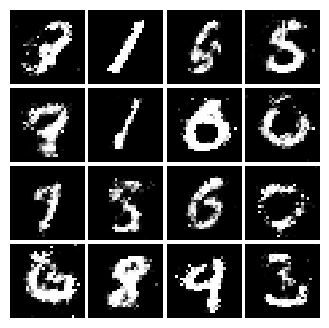


Iter: 3500, D: 0.2228, G:0.1758


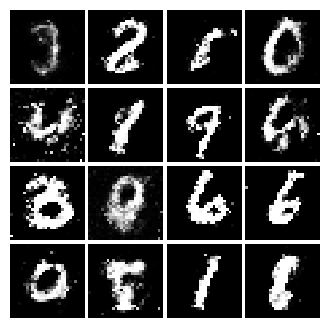


***************** running Epoch*********************  9
Iter: 3750, D: 0.216, G:0.17


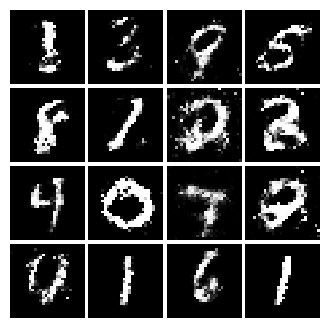

In [ ]:


D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

git_ls_history = run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss2, ls_generator_loss2)
create_checkpoint(LS_G,LS_D,LS_G_SOLVER,LS_D_SOLVER,ls_history,'ls_fromgit_gan_my_checkpoint.pth')


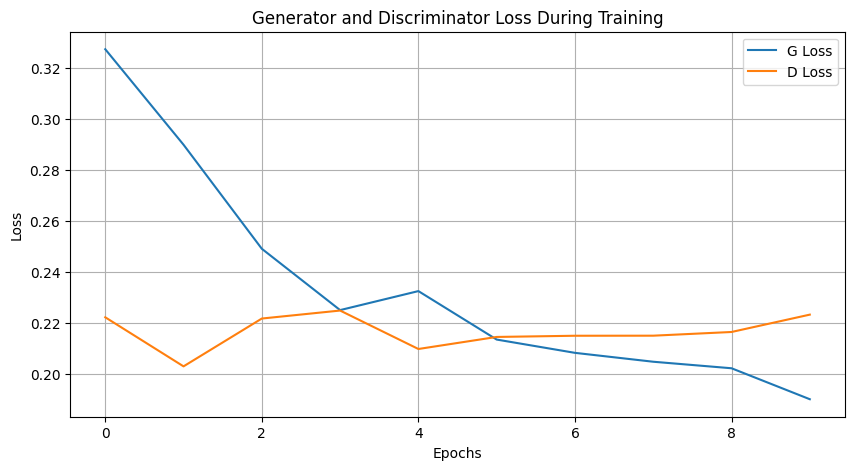

In [ ]:
plot_gan_losses(git_ls_history)

formula 2 makes generator and discriminator competitive
It pushes the fake images towards real images.

## Formula 2 & increase model layers

***************** running Epoch*********************  0
Iter: 0, D: 0.4644, G:0.4266


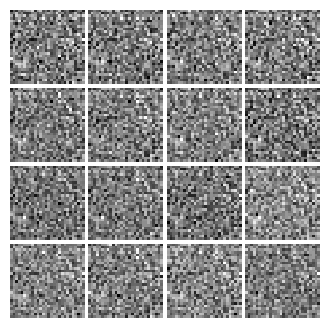


Iter: 250, D: 0.08101, G:0.4574


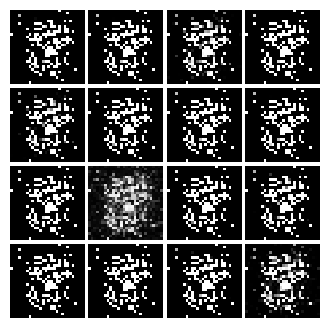


***************** running Epoch*********************  1
Iter: 500, D: 0.1665, G:0.3877


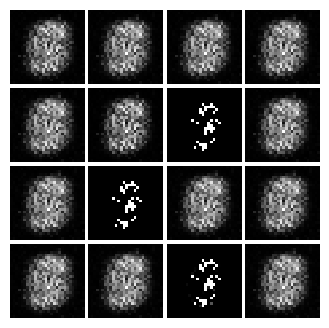


Iter: 750, D: 0.2158, G:0.1849


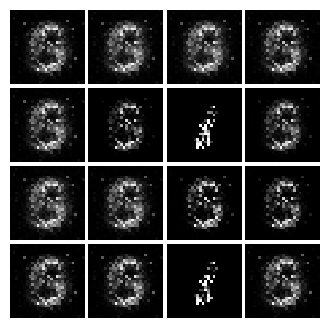


***************** running Epoch*********************  2
Iter: 1000, D: 0.1381, G:0.248


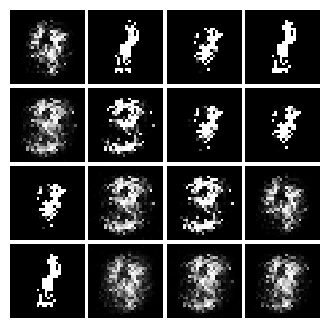


***************** running Epoch*********************  3
Iter: 1250, D: 0.1612, G:0.3288


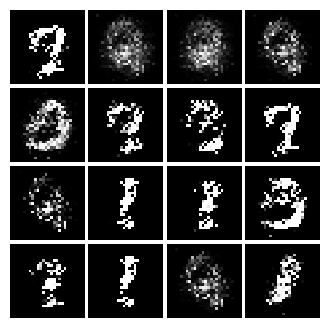


Iter: 1500, D: 0.2303, G:0.1483


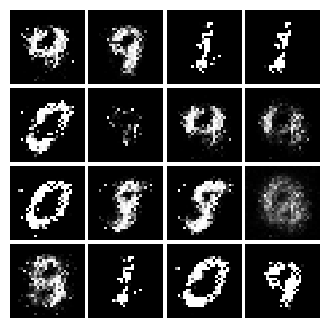


***************** running Epoch*********************  4
Iter: 1750, D: 0.1662, G:0.2228


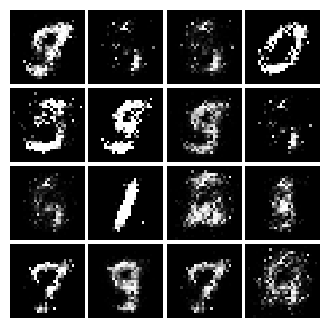


***************** running Epoch*********************  5
Iter: 2000, D: 0.2226, G:0.2254


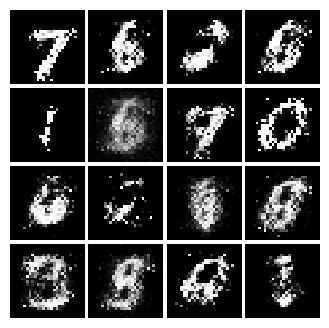


Iter: 2250, D: 0.1821, G:0.2185


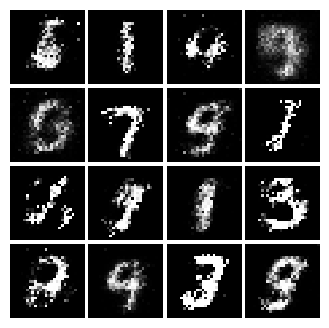


***************** running Epoch*********************  6
Iter: 2500, D: 0.1728, G:0.2401


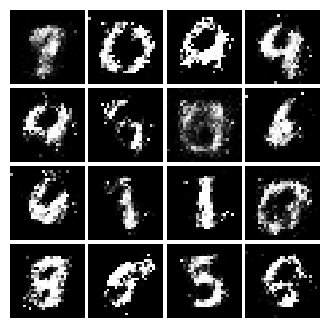


***************** running Epoch*********************  7
Iter: 2750, D: 0.1903, G:0.2464


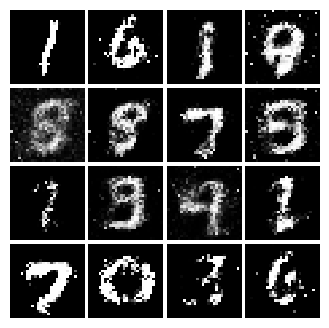


Iter: 3000, D: 0.2842, G:0.3514


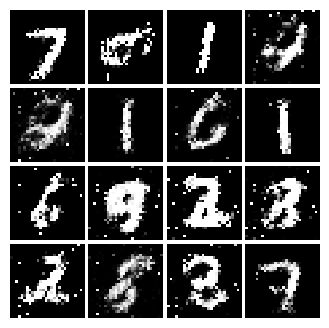


***************** running Epoch*********************  8
Iter: 3250, D: 0.2078, G:0.2671


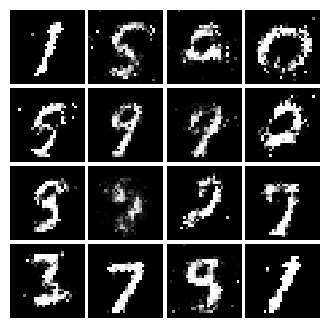


Iter: 3500, D: 0.1869, G:0.2487


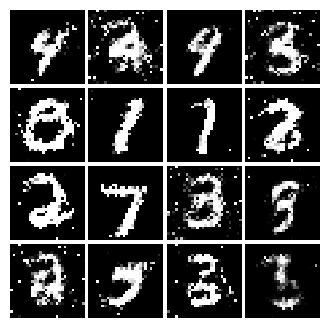


***************** running Epoch*********************  9
Iter: 3750, D: 0.1974, G:0.2423


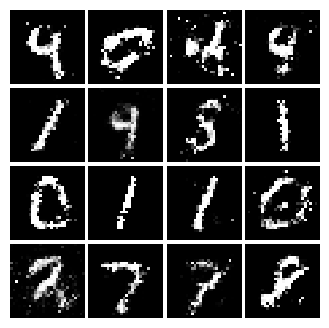

In [ ]:
# model

D_LS = discriminator().type(dtype)
G_LS = generator().type(dtype)

D_LS_solver = get_optimizer(D_LS)
G_LS_solver = get_optimizer(G_LS)

git_ls_lg_history = run_a_gan(D_LS, G_LS, D_LS_solver, G_LS_solver, ls_discriminator_loss2, ls_generator_loss2)
create_checkpoint(LS_G,LS_D,LS_G_SOLVER,LS_D_SOLVER,ls_history,'ls_fromgit_lgSizeModel__gan_my_checkpoint.pth')


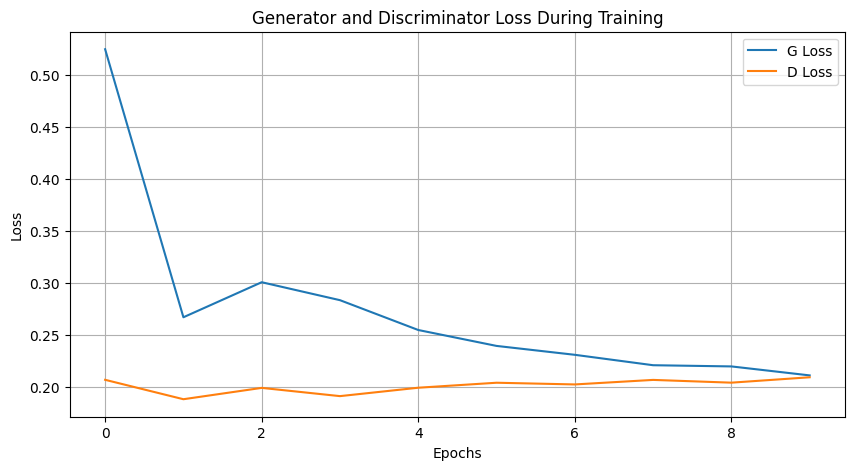

In [ ]:
plot_gan_losses(git_ls_lg_history)

On using Formula 2 and Increasing Model Layers GAN performs well and both Generator & discriminator become equally good and are in equilibrium

## Formula 1 & Increase Model Layers


***************** running Epoch*********************  0
Iter: 0, D: 0.9703, G:4.711e-06


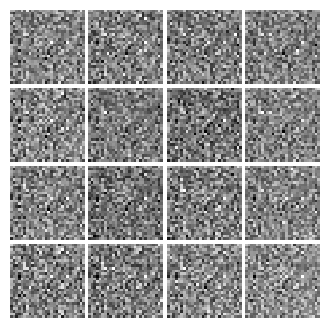


Iter: 250, D: 0.6185, G:0.1047


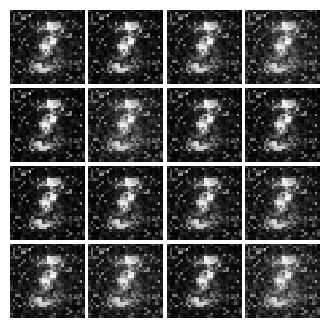


***************** running Epoch*********************  1
Iter: 500, D: 0.5608, G:0.1401


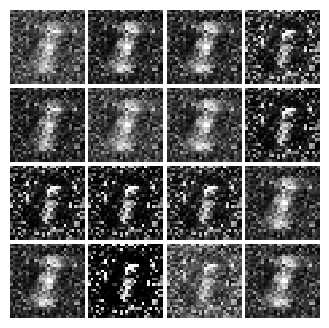


Iter: 750, D: 0.7073, G:0.05821


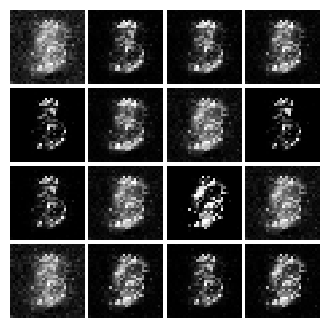


***************** running Epoch*********************  2
Iter: 1000, D: 0.5121, G:0.2389


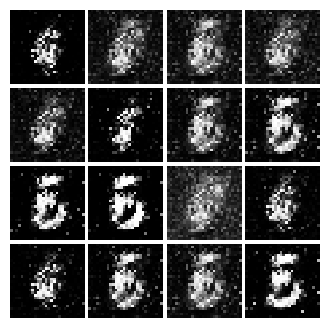


***************** running Epoch*********************  3
Iter: 1250, D: 0.5415, G:0.1676


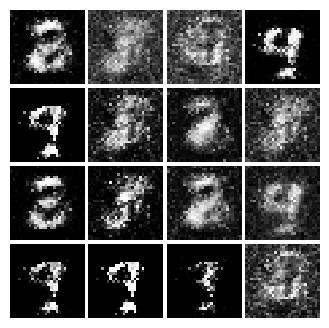


Iter: 1500, D: 0.8734, G:0.1276


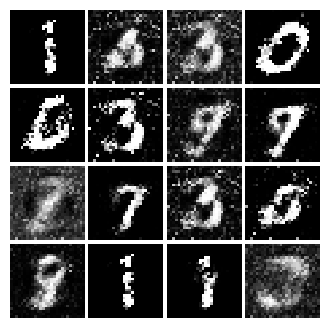


***************** running Epoch*********************  4
Iter: 1750, D: 0.8247, G:0.08606


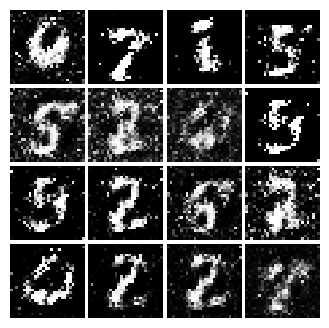


***************** running Epoch*********************  5
Iter: 2000, D: 0.8636, G:0.06508


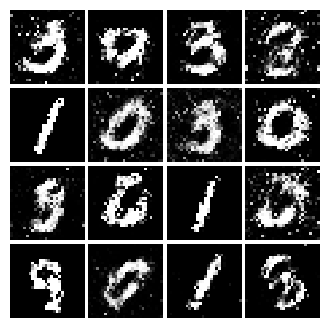


Iter: 2250, D: 0.6158, G:0.1709


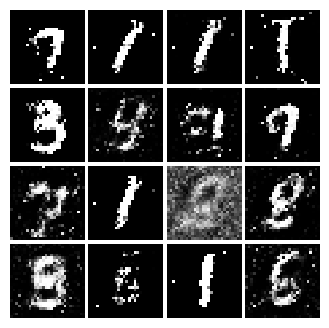


***************** running Epoch*********************  6
Iter: 2500, D: 0.5666, G:0.3827


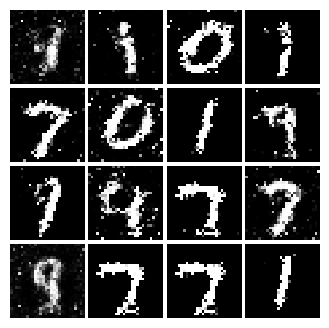


***************** running Epoch*********************  7
Iter: 2750, D: 0.613, G:0.1288


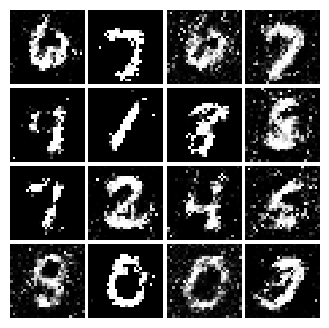


Iter: 3000, D: 0.6863, G:0.1032


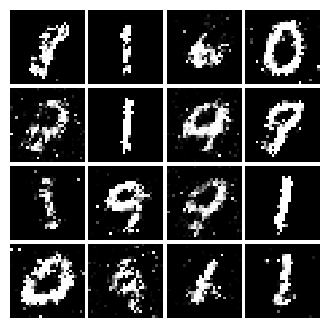


***************** running Epoch*********************  8
Iter: 3250, D: 0.5347, G:0.2281


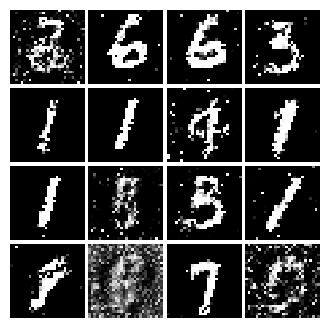


Iter: 3500, D: 0.1344, G:0.3056


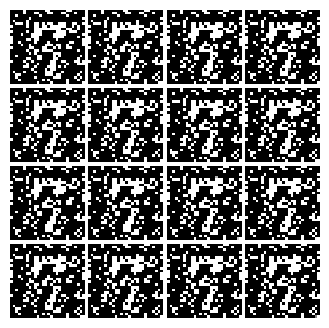


***************** running Epoch*********************  9
Iter: 3750, D: 0.01969, G:0.5083


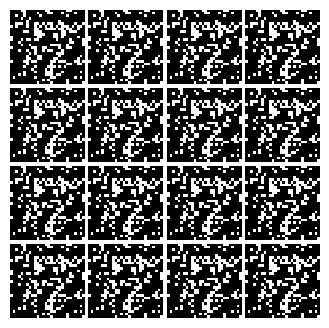

In [ ]:

LS_D = discriminator().type(dtype)
LS_G = generator().type(dtype)

LS_D_SOLVER = get_optimizer(LS_D)
LS_G_SOLVER = get_optimizer(LS_G)

ls2_history = run_a_gan(LS_D,LS_G,LS_D_SOLVER,LS_G_SOLVER,ls_discriminator_loss,ls_generator_loss)
create_checkpoint(LS_G,LS_D,LS_G_SOLVER,LS_D_SOLVER,ls2_history,'ls2_gan_my_checkpoint.pth')


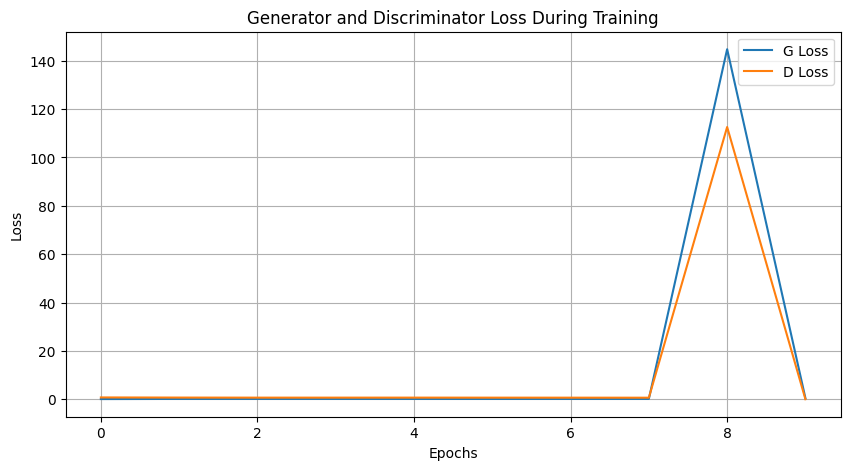

In [ ]:
plot_gan_losses(ls2_history)

On Increasing model Layers and using Formula 1 GAN doesn't perform well during training, training becomes unstable after epcoh 8 and it produces pure random noise

## Conclusion
Formula 1 is unstable. In formula 1 generator is pulling fake samples closer to 0 -> decision boundary whereas discriminator classisfies real image as 1 and fake as -1.

In Formula 2 . Generator is pulling fake samples closer to real samples. Thus giving better results under practical conditions.


**Both Forumla 1 and formula 2 are correct. Forumla 1 is pure mathematical way to minimize pearson X^2 divergence but does not helps generator in producing images closer to real images as its goal is to push output images closer to decision boundary. **


**Adding more layers to Generator and Discriminator leads to better results. **